In [24]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import math
import random
from sklearn.utils import resample
from sklearn.externals import joblib
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score
import xgboost as xgb


import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# IMPORT DATA

In [20]:
#import Pickled Data

X_train = pickle.load(open("X_train_features.pkl", 'rb'))
y_train = pickle.load(open("y_train_features.pkl", 'rb'))
X_validation = pickle.load(open("X_validation_features.pkl", 'rb'))
y_validation = pickle.load(open("y_validation_features.pkl", 'rb'))
X_test = pickle.load(open("X_test_features.pkl", 'rb'))

#non-linear pickled data import
X_train_X = pickle.load(open("X_train_features_X.pkl", 'rb'))
y_train_X = pickle.load(open("y_train_features_X.pkl", 'rb'))
X_validation_X = pickle.load(open("X_validation_features_X.pkl", 'rb'))
y_validation_X = pickle.load(open("y_validation_features_X.pkl", 'rb'))
X_test_X = pickle.load(open("X_test_features_X.pkl", 'rb'))

X_train_pay = pickle.load(open("X_train_pay.pkl", 'rb'))

Lin_features = pickle.load(open('bestFeatures.pkl', 'rb'))
Lin_features_X = pickle.load(open('bestFeatures_X.pkl', 'rb'))

#Liimit the input data by the feature columns
feature_X_train_L = X_train[Lin_features].values
feature_X_val_L = X_validation[Lin_features].values
feature_X_test_L = X_test[Lin_features].values

In [16]:
#import unprocessed original data

traindf = pd.read_csv("train.csv")
validationdf = pd.read_csv("validation.csv")
testdf = pd.read_csv("test.csv")


In [18]:
#Liimit the input data by the feature columns

feature_X_train = X_train[Lin_features].values
feature_X_val = X_validation[Lin_features].values
feature_X_test = X_test[Lin_features].values

feature_X_train_X = X_train_X[Lin_features_X].values
feature_X_val_X = X_validation_X[Lin_features_X].values
feature_X_test_X = X_test_X[Lin_features_X].values


In [19]:
'''
Creating the necessary variables for the the average CTR 
and the range which will be used to test the base bid
'''
avgCTR = traindf["click"].sum()*100/traindf.shape[0]
bid_list = range(100,150, 5)


avgBid_training = traindf.loc[traindf["click"] == 1, "payprice"].mean()
print("In the training data, the average CTR is: %.4f , and the average BID is: $%.2f"
      % (avgCTR, avgBid_training))


In the training data, the average CTR is: 0.0738 , and the average BID is: $105.46


# XGB

In [28]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', colsample_bytree = 0.2, learning_rate = 0.1,
               max_depth = 5, alpha = 10, n_estimators = 500, random_state = 123)

xgb_clf.fit(feature_X_train, y_train)


predict_proba_list_val = xgb_clf.predict_proba(feature_X_val)

predict_proba_list_test = xgb_clf.predict_proba(feature_X_test)

validationdf['click_proba_xgb'] = [item[1] for item in predict_proba_list_val]
testdf['click_proba_xgb'] = [item[1] for item in predict_proba_list_test]

In [29]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', colsample_bytree = 0.2, learning_rate = 0.1,
              max_depth = 5, alpha = 10, n_estimators = 500, random_state = 123)
xgb_clf.fit(feature_X_train_X ,y_train)

x_predict = xgb_clf.predict(feature_X_val_X )

x_predict_proba_list = xgb_clf.predict_proba(feature_X_val_X)
validationdf['click_proba_XGBOOST'] = [item[1] for item in x_predict_proba_list]

x_predict_proba_list_test = xgb_clf.predict_proba(feature_X_test_X)
testdf['click_proba_XGBOOST'] = [item[1] for item in x_predict_proba_list_test]

pCTR_test_X = testdf['click_proba_XGBOOST']

In [31]:
#seperate
pCTR_val_L=validationdf['click_proba_log']
pCTR_val_X=validationdf['click_proba_XGBOOST']
#avg
col = validationdf.loc[: , 'click_proba_log':'click_proba_XGBOOST']
pCTR_avg=col.mean(axis=1)
#max
pCTR_max=col.max(axis=1)

In [46]:
###CONSTANT DEFITIONS
c_optimum=0.103
ld_optimum=5.95*10**-7
base_bid = 115
budget = 6250000

In [35]:
#ORTB on the validation set 
def ORTB_val(c,ld, pCTR = pCTR_val_X, budget = budget, df = validationdf):   
    counter = 0
    clicks = 0
    imp = 0
    bid_ORTB=np.sqrt(c*pCTR/ld + c**2)-c
    while ((budget >= 0) & (counter < len(df))):
        if pCTR[counter]>0:
            if(df['payprice'][counter] < bid_ORTB[counter]):
                budget -= df['payprice'][counter]
                clicks += df['click'][counter]
                imp += 1
        counter += 1

    return clicks, imp, bid_ORTB

#ORTB on the test set
def ORTB_test(c,ld, pCTR = pCTR_test_X, budget = budget, df = testdf):   
    bid_ORTB=np.sqrt(c*pCTR/ld + c**2)-c

    return bid_ORTB

# MULTI AGENT 

In [48]:
###Multi-agent evaluation method###

import heapq
def evaluate_mult(agent_bids, budget = 6250000):
    
    agent_num = len(agent_bids)
    counter = 0
    clicks = [0] * agent_num
    imp =[0] * agent_num
    spent = [0] * agent_num
    agent_budget = [budget] * agent_num

    while ((any(x > 0 for x in agent_budget)) & (counter < len(validationdf))):
        #assign current round of bids to one array
        curr_bids = [item[counter] for item in agent_bids]
        #check for budget; if agent runs out of budget, set current round's bid to 0
        for i in range(agent_num):
            #set their bid to 0 if they run out of budget
            if agent_budget[i] <= 0:
                curr_bids[i] = 0

        if(any(y >= validationdf['payprice'][counter] for y in curr_bids)):
            #add payprice to list of bid prices to compare
            curr_bids.append(validationdf['payprice'][counter])
            #deduct second price from winning bid's budget
            agent_budget[curr_bids.index(max(curr_bids))] -= heapq.nlargest(2, curr_bids)[1]
            #return bid results
            clicks[curr_bids.index(max(curr_bids))] += validationdf['click'][counter]
            spent[curr_bids.index(max(curr_bids))] += heapq.nlargest(2, curr_bids)[1]
            imp[curr_bids.index(max(curr_bids))] += 1
        counter += 1
    
    
    return clicks, spent, imp

In [41]:
def print_results(evaluation):
    agent_num = len(evaluation[0])
    agents_ctr = [0] * agent_num
    agents_cpm = [0] * agent_num
    agents_cpc = [0] * agent_num
    for i in range(agent_num):
        if(evaluation[2][i] == 0):
            agents_ctr[i] = 0
            agents_cpm[i] = 0
            agents_cpc[i] = 0
        else:
            agents_ctr[i] = evaluation[0][i] / evaluation[2][i]
            agents_cpm[i] = evaluation[1][i] / evaluation[2][i]
            agents_cpc[i] = evaluation[1][i] / evaluation[0][i] / 1000
    
    print("Agent clicks: ", evaluation[0])
    print("Agent spending: ", evaluation[1])
    print("Agent impressions: ", evaluation[2])
    print("Agent CTRs: ", agents_ctr)
    print("Agent CPMs: ", agents_cpm)
    print("Agent CPCs: ", agents_cpc)

Agent clicks:  [47, 108]
Agent spending:  [5133701.0, 3059185.980479075]
Agent impressions:  [126976, 12698]
Agent CTRs:  [0.00037014868951612903, 0.008505276421483698]
Agent CPMs:  [40.430482925907256, 240.91872582131637]
Agent CPCs:  [109.22768085106384, 28.325796115546993]


In [43]:
#define method for outputting leaderboard submission csv 
def lead_bid(bid): 
    output = pd.DataFrame(testdf["bidid"])
    output = output.join(pd.DataFrame(bid))
    output.to_csv('testing_bidding_price.csv', header = ["bidid","bidprice"], index = None)

In [94]:
def str_top(c, ld, pCTR = pCTR_val_X, budget = budget, df = validationdf):
    mid_ctr_ind = df.click_proba_XGBOOST.loc[(df.click_proba_XGBOOST <= 0.95)].index.values
    ok_ctr_ind = df.click_proba_XGBOOST.loc[(df.click_proba_XGBOOST > 0.95)].index.values
    
    bid_ORTB = np.sqrt(c*pCTR/ld + c**2)-c
    mid_val = sum(bid_ORTB[mid_ctr_ind])/len(ok_ctr_ind)
    
    bid_ORTB[mid_ctr_ind] = 0
    bid_ORTB[ok_ctr_ind] = [x + mid_val for x in bid_ORTB[ok_ctr_ind]]
        
    return bid_ORTB

def str_bot(c, ld, pCTR = pCTR_val_X, budget = budget, df = validationdf):
    mid_ctr_ind = df.click_proba_XGBOOST.loc[(df.click_proba_XGBOOST > 0.2)].index.values
    ok_ctr_ind = df.click_proba_XGBOOST.loc[(df.click_proba_XGBOOST <= 0.2)].index.values
    
    bid_ORTB = np.sqrt(c*pCTR/ld + c**2)-c
    mid_val = sum(bid_ORTB[mid_ctr_ind])/len(ok_ctr_ind)
    
    bid_ORTB[mid_ctr_ind] = 0
    bid_ORTB[ok_ctr_ind] = [x + mid_val for x in bid_ORTB[ok_ctr_ind]]
        
    return bid_ORTB

def str_top_bot(c, ld, pCTR = pCTR_val_X, budget = budget, df = validationdf):
    mid_ctr_ind = df.click_proba_XGBOOST.loc[(df.click_proba_XGBOOST <= 0.8) & 
                                            (df.click_proba_XGBOOST >= 0.2)].index.values
    ok_ctr_ind = df.click_proba_XGBOOST.loc[(df.click_proba_XGBOOST > 0.8) | 
                                            (df.click_proba_XGBOOST < 0.2)].index.values
    
    bid_ORTB = np.sqrt(c*pCTR/ld + c**2)-c
    mid_val = sum(bid_ORTB[mid_ctr_ind])/len(ok_ctr_ind)
    
    bid_ORTB[mid_ctr_ind] = 0
    bid_ORTB[ok_ctr_ind] = [x + mid_val for x in bid_ORTB[ok_ctr_ind]]
        
    return bid_ORTB

def str_50_50(c, ld, pCTR = pCTR_val_X, budget = budget, df = validationdf):
    
    mid_ctr_ind = df.click_proba_XGBOOST.loc[(df.click_proba_XGBOOST <= 0.5)].index.values
    ok_ctr_ind = df.click_proba_XGBOOST.loc[(df.click_proba_XGBOOST > 0.5)].index.values
    
    bid_ORTB = np.sqrt(c*pCTR/ld + c**2)-c
    mid_val = sum(bid_ORTB[mid_ctr_ind])/len(ok_ctr_ind)
    
    bid_ORTB[mid_ctr_ind] = 0
    bid_ORTB[ok_ctr_ind] = [x + mid_val for x in bid_ORTB[ok_ctr_ind]]
        
    return bid_ORTB

def str_top_emph(c, ld, pCTR = pCTR_val_X, budget = budget, df = validationdf):   
    mid_ctr_ind = df.click_proba_XGBOOST.loc[(df.click_proba_XGBOOST <= 0.95) & 
                                            (df.click_proba_XGBOOST >= 0.2)].index.values
    ok_ctr_ind = df.click_proba_XGBOOST.loc[(df.click_proba_XGBOOST > 0.95)].index.values
    
    toss_ctr_ind = df.click_proba_XGBOOST.loc[(df.click_proba_XGBOOST < 0.2)].index.values
    
    bid_ORTB = np.sqrt(c*pCTR/ld + c**2)-c
    mid_val = sum(bid_ORTB[toss_ctr_ind])/len(ok_ctr_ind)
    
    bid_ORTB[mid_ctr_ind] = [x + 10 for x in bid_ORTB[mid_ctr_ind]]
    bid_ORTB[ok_ctr_ind] = [x + (mid_val+100) for x in bid_ORTB[ok_ctr_ind]]
    bid_ORTB[toss_ctr_ind] = 0
        
    return bid_ORTB

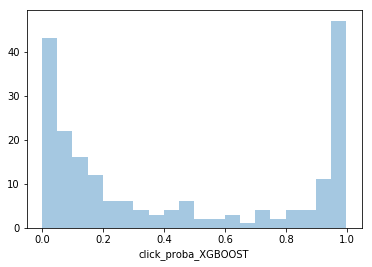

In [89]:
#visualising the distribution of clicks with pCTRs from our baseline strategy
sns.distplot(validationdf.filter(regex = "click").loc[validationdf["click"] == 1]["click_proba_XGBOOST"],
            kde = None, bins = 20)

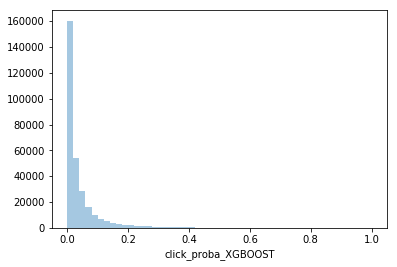

In [62]:
#visualising the overall distribution of pCTR of the validation set
sns.distplot(validationdf.click_proba_XGBOOST, kde = None)

In [95]:
print_results(evaluate_mult([ORTB_val(c_optimum, ld_optimum)[2],
                                 str_top(c_optimum, ld_optimum)]))

print_results(evaluate_mult([ORTB_val(c_optimum, ld_optimum)[2],
                                 str_bot(c_optimum, ld_optimum)]))

print_results(evaluate_mult([ORTB_val(c_optimum, ld_optimum)[2],
                                 str_top_bot(c_optimum, ld_optimum)]))

print_results(evaluate_mult([ORTB_val(c_optimum, ld_optimum)[2],
                                 str_50_50(c_optimum, ld_optimum)]))

print_results(evaluate_mult([ORTB_val(c_optimum, ld_optimum)[2],
                                 str_top_emph(c_optimum, ld_optimum)]))

Agent clicks:  [107, 47]
Agent spending:  [6130961.0, 59777.30655169071]
Agent impressions:  [139418, 145]
Agent CTRs:  [0.0007674762225824499, 0.32413793103448274]
Agent CPMs:  [43.97539055215252, 412.2572865633842]
Agent CPCs:  [57.298700934579436, 1.2718575862061852]
Agent clicks:  [132, 24]
Agent spending:  [3392606, 6250012.174881717]
Agent impressions:  [71301, 79793]
Agent CTRs:  [0.0018513064332898556, 0.0003007782637574725]
Agent CPMs:  [47.581464495589124, 78.3278254343328]
Agent CPCs:  [25.701560606060607, 260.41717395340487]
Agent clicks:  [100, 56]
Agent spending:  [3391333, 6250018.132363676]
Agent impressions:  [71572, 78909]
Agent CTRs:  [0.0013971944335773767, 0.0007096782369564942]
Agent CPMs:  [47.38351590007265, 79.2053901628924]
Agent CPCs:  [33.91333, 111.60746664935137]
Agent clicks:  [74, 80]
Agent spending:  [5972843.0, 622694.5429149121]
Agent impressions:  [137714, 1849]
Agent CTRs:  [0.0005373455131649651, 0.04326663061114116]
Agent CPMs:  [43.37135657957796